<a href="https://colab.research.google.com/github/Stevebankz/Covid19-Prediction/blob/main/Covid19-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Open file from G-Drive

In [ ]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
#Get the file
downloaded = drive.CreateFile({'id':"1IdzmCg_b0ixzh-ramWYmY04M1IHqwSFW"})
downloaded.GetContentFile('data.csv')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import math


Load data

In [ ]:
corona_df = pd.read_csv('data.csv')

Preparation data

In [ ]:
#Check first record
#*** Edit Here (1 point) ***
#hint: print(...)
corona_df.head(1)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [ ]:
#Check last record
#*** Edit Here (1 point) ***
corona_df.tail(1)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
15130,15131,04/14/2020,Zhejiang,Mainland China,2020-04-14 23:41:11,1267.0,1.0,1242.0


In [ ]:
#******Data Transformation*****
#renaming ObservationDate to Date and Country/Region to Country.
corona_df.rename(columns={'ObservationDate': 'Date',
                          'Country/Region': 'Country'}, inplace=True)

In [ ]:
#verifying the datatype of the corona_df. Before making the model,
# all the independent variables should be in the numerical format except date.
print(corona_df.dtypes)
print(corona_df.shape)

SNo                 int64
Date               object
Province/State     object
Country            object
Last Update        object
Confirmed         float64
Deaths            float64
Recovered         float64
dtype: object
(15131, 8)


In [ ]:
#Normalize the data.
#checking any null values in any columns.
#hint check isnull and sum null frame

print(corona_df.isna().sum())

SNo                  0
Date                 0
Province/State    7467
Country              0
Last Update          0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64


In [ ]:
# Only Province column has the null values. Try to replace those values.
corona_df["Province/State"].fillna("NA", inplace=True)

Try Descriptive analysis

In [ ]:
#show describe of corona dataframe
corona_df.describe()

,SNo,Confirmed,Deaths,Recovered
count,15131.000000,15131.000000,15131.000000,15131.000000
mean,7566.000000,2061.836759,108.210165,502.725530
std,4368.087797,11189.202681,913.498994,4117.613616
min,1.000000,0.000000,0.000000,0.000000
25%,3783.500000,6.000000,0.000000,0.000000
50%,7566.000000,72.000000,1.000000,1.000000
75%,11348.500000,481.000000,5.000000,37.000000
max,15131.000000,203020.000000,21067.000000,68200.000000


In [ ]:
####################################
## Exploratory Analysis           ##
# ##################################
# Let's get the total Confirmed, Deaths and Recovered cases in the world(till 04/14).
#Groupby date and country.
corona_df = corona_df.groupby(["Date", "Country"])[
    ['Date', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
corona_sorted_df = corona_df.sort_values('Date', ascending=False)

#Drop the duplicates country
corona_sorted_df = corona_sorted_df.drop_duplicates('Country')

# Now, I have all the unique date in the date column with country.
print(corona_sorted_df.head(80))

            Date              Country  Confirmed  Deaths  Recovered
8108  04/14/2020             Zimbabwe       17.0     3.0        0.0
7980  04/14/2020              Finland     3161.0    64.0      300.0
7989  04/14/2020            Guatemala      167.0     5.0       19.0
7988  04/14/2020              Grenada       14.0     0.0        0.0
7987  04/14/2020               Greece     2170.0   101.0      269.0
...          ...                  ...        ...     ...        ...
7963  04/14/2020                 Cuba      766.0    21.0      132.0
7962  04/14/2020              Croatia     1704.0    31.0      415.0
7961  04/14/2020           Costa Rica      618.0     3.0       66.0
7960  04/14/2020     Congo (Kinshasa)      241.0    20.0       20.0
7959  04/14/2020  Congo (Brazzaville)       60.0     5.0        5.0

[80 rows x 5 columns]


<ipython-input-20-ab52c9c6c11a>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ['Date', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()


In [ ]:

#Find Total Confirmed cases  in the world (1 point)
corona_confirmed_total_df = corona_sorted_df['Confirmed'].sum()

#Find Total Deaths cases in the world (1 point)
corona_deaths_total_df = corona_sorted_df['Deaths'].sum()

#Find Total Recovered cases in the world (1 point)
corona_recovered_total_df = corona_sorted_df['Recovered'].sum()

corona_confirmed_total_df = round(corona_confirmed_total_df, 2)
corona_deaths_total_df = round(corona_deaths_total_df, 2)
corona_recovered_total_df = round(corona_recovered_total_df, 2)

corona_dict = {'Total Confirmed cases  in the world': corona_confirmed_total_df,
               'Total Deaths cases in the world': corona_deaths_total_df, 'Total Recovered cases in the world': corona_recovered_total_df}
corona_dict = pd.DataFrame.from_dict(
    corona_dict, orient='index', columns=['Total'])

print(corona_dict)


                                         Total
Total Confirmed cases  in the world  1977127.0
Total Deaths cases in the world       125994.0
Total Recovered cases in the world    474835.0


In [ ]:
# Top 10  infected Countries
corona_sorted_df.sort_values('Confirmed', ascending=False).head(10)

,Date,Country,Confirmed,Deaths,Recovered
8096,04/14/2020,US,607670.0,25832.0,47763.0
8080,04/14/2020,Spain,172541.0,18056.0,67504.0
8005,04/14/2020,Italy,162488.0,21067.0,37130.0
7981,04/14/2020,France,131361.0,15748.0,29098.0
7985,04/14/2020,Germany,131359.0,3294.0,68200.0
8095,04/14/2020,UK,94845.0,12129.0,323.0
8026,04/14/2020,Mainland China,82249.0,3341.0,77753.0
8001,04/14/2020,Iran,74877.0,4683.0,48129.0
8094,04/14/2020,Turkey,65111.0,1403.0,4799.0
7938,04/14/2020,Belgium,31119.0,4157.0,6868.0


<ipython-input-23-2c25ec21f1ec>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_cases_per_day = corona_df.groupby(


Blue : Confirmed Cases 
Red : Death Cases 
Green : Recovered Cases 


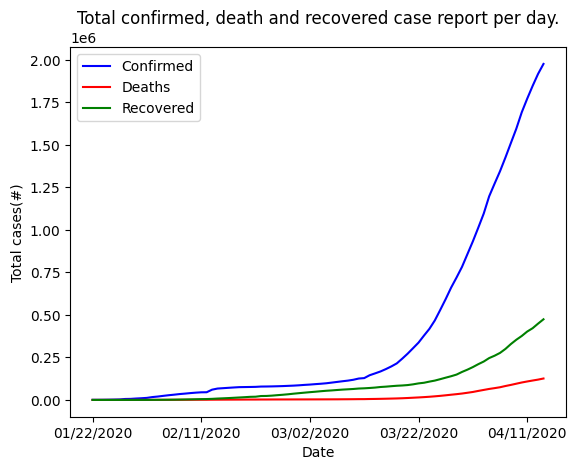

In [ ]:
# Table that illustrates increasing infections cases in the world per day .
corona_cases_per_day = corona_df.groupby(
    ["Date"])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
sorted_By_Confirmed1 = corona_cases_per_day.sort_values(
    'Date', ascending=False)

sorted_By_Confirmed1.style.background_gradient(cmap='Reds')

# Line graph that illustrates increasing infections cases per day.
x = corona_cases_per_day.Date
y = corona_cases_per_day.Confirmed
y1 = corona_cases_per_day.Deaths
y2 = corona_cases_per_day.Recovered
ax = plt.gca()
corona_cases_per_day.plot(kind='line', x='Date',
                          y='Confirmed', color='blue', ax=ax)
corona_cases_per_day.plot(kind='line', x='Date',
                          y='Deaths', color='red', ax=ax)
corona_cases_per_day.plot(kind='line', x='Date',
                          y='Recovered', color='green', ax=ax)
print("Blue : Confirmed Cases ")
print("Red : Death Cases ")
print("Green : Recovered Cases ")
plt.ylabel('Total cases(#)')
plt.title('Total confirmed, death and recovered case report per day.')
plt.show()

In [ ]:
# prepare the data for the prediction.
# converting Date column of dataset to numeric for ensuring the independent variable should be on the same scale as other.
# In the date, I assume the start date as 0 (first day) when the COVID-19 had started and increasing by 1 over increament in date.
# Splitting corona data into Date and confirmed cases.
corona_index_df = pd.DataFrame(corona_cases_per_day.index)
corona_confirmed_df = pd.DataFrame(corona_cases_per_day.Confirmed)
corona_recovered_df = pd.DataFrame(corona_cases_per_day.Recovered)
corona_death_df = pd.DataFrame(corona_cases_per_day.Deaths)


In [ ]:
####################################
## Prepare dataset for model      ##
###################################

# Splitting the data.
# Here, I am preparing the train, validate and test dataset.
# Using 90% of the data to train the model.
x_days_train = corona_index_df[0:78]
x_days_validate = corona_index_df[78:82]
x_days_test = corona_index_df[82:84]

# Confirmed
y_confirmed_train = corona_confirmed_df[0:78]
y_confirmed_validate = corona_confirmed_df[78:82]
y_confirmed_test = corona_confirmed_df[82:84]


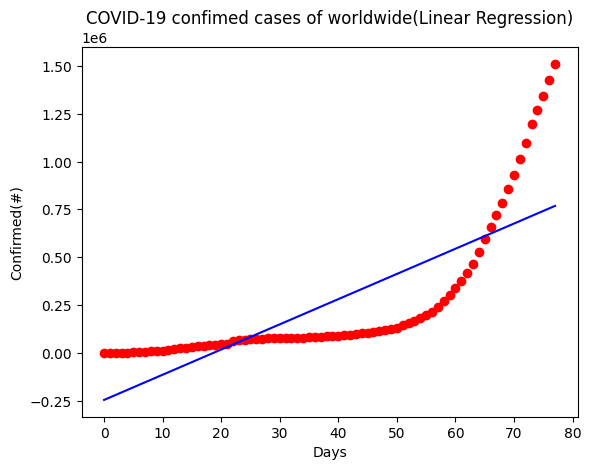

In [ ]:
####################################
##  Regression Model             ##
###################################

# Let's apply Linear regression model on the dataset. As I can see, all the data are continuous,
#I think that Linear regression will be perfect.
# Linear regression
ln_model = LinearRegression()
ln_model.fit(x_days_train,y_confirmed_train[['Confirmed']])

plt.scatter(x_days_train, y_confirmed_train, color='red')
plt.plot(x_days_train, ln_model.predict(x_days_train), color='blue')
plt.title('COVID-19 confimed cases of worldwide(Linear Regression)')
plt.xlabel('Days')
plt.ylabel('Confirmed(#)')
plt.show()



In [ ]:
# # After applying the linear regression, the predicted line do not fit with the independent variables.
# # It means that the line is unable to capture the patterns in the data. This may be an example of under-fitting.
# # For confirmation, lets check the rmse and r2 score for the model.

r2 = r2_score(x_days_validate,y_confirmed_validate)
print('Linear Regession  R2 Score   : ', r2)

rmse = mean_squared_error(x_days_validate,y_confirmed_validate)
print('RMSE of Linear regression is :', rmse)


Linear Regession  R2 Score   :  -2390888985347.2
RMSE of Linear regression is : 2988611231685.25


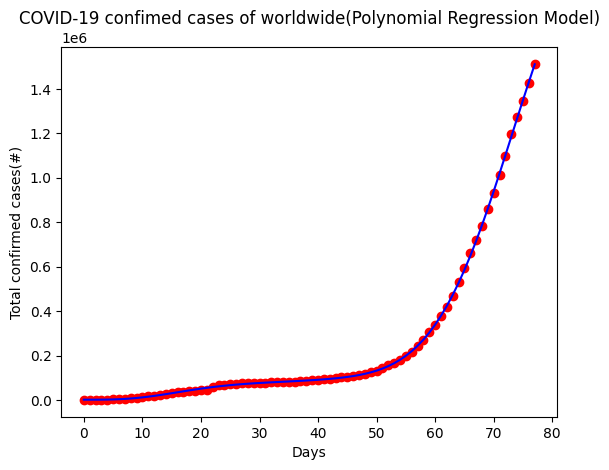

In [ ]:
# Now, to overcome the under-fitting problem, to increase the complexity of the model.
# Here, used Polynomial linear regression technique because it best fit for the prediction of how deceases spread accross the territory or the world.
# Polynomial linear regression to predict future confirmed cases.

# Polynomal linear Regression (degree=10)
poly_reg = PolynomialFeatures(degree=10)

# Model training with the train data.
x_poly = poly_reg.fit_transform(x_days_train)

# Applying linear regression.
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y_confirmed_train)

# Graphical summary of the model.
plt.scatter(x_days_train, y_confirmed_train, color='red')
plt.plot(x_days_train, lin_reg.predict(
    poly_reg.fit_transform(x_days_train)), color='blue')
plt.title("COVID-19 confimed cases of worldwide(Polynomial Regression Model)")
plt.xlabel('Days')
plt.ylabel('Total confirmed cases(#)')
plt.show()


In [ ]:
# It seems that the polynomial line connects all the dots.
# Now, let's validate the model with the x_days_validate which contains index.
# For the index, the model will predict the confirmed cases of the data.
y_pred = lin_reg.predict(poly_reg.fit_transform(x_days_validate))
result = pd.DataFrame(y_pred)
result['Real Value'] = y_confirmed_validate.iloc[:, :].values
result['Predicted Value'] = pd.DataFrame(y_pred)
result = result[['Real Value', 'Predicted Value']]
print(result)


   Real Value  Predicted Value
0   1595350.0     1.586618e+06
1   1691719.0     1.662180e+06
2   1771514.0     1.736668e+06
3   1846680.0     1.811459e+06


In [ ]:
# Now, as per the model,let's check the accuracy of the model on validate data set.
r2_score(y_confirmed_validate, y_pred)
print('Polynomial Regession  R2 Score   : ', r2)
rmse = np.sqrt(mean_squared_error(y_confirmed_validate, y_pred))
print('RMSE of polynomial regression is :', rmse)

# However, let's apply the accurate model for test data.
y_confirmed_test_pred = lin_reg.predict(poly_reg.fit_transform(x_days_test))
predicted_result = pd.DataFrame(y_confirmed_test_pred)
predicted_result['Real Test Value'] = y_confirmed_test.iloc[:, :].values
predicted_result['Predicted Test Value'] = pd.DataFrame(y_confirmed_test_pred)
predicted_result = predicted_result[[
    'Real Test Value', 'Predicted Test Value']]
print(predicted_result)


Polynomial Regession  R2 Score   :  -2390888985347.2
RMSE of polynomial regression is : 29169.998180765157
   Real Test Value  Predicted Test Value
0        1917320.0          1.888822e+06
1        1976192.0          1.972141e+06
